# Patient Treatment 

Data Set Information:

    * The data set features patient information from a private Hospital in Indonesia. It contains the patients' laboratory test results that are used to determine whether a patient's next treatment is as an in care patient or out care patient. The task embedded to the dataset is classification prediction. 


Attribute Information:

    * Given is the attribute name, attribute type, the measurement unit and a brief description. The source variable will be used as the response variable for classification.

Name / Data Type / Value Sample/ Description: 

    * HAEMATOCRIT/Continuous/35.1/Patient laboratory test result of haematocrit
    * HAEMOGLOBINS/Continuous/11.8/Patient laboratory test result of haemoglobins
    * ERYTHROCYTE/Continuous/4.65/Patient laboratory test result of erythrocyte
    * LEUCOCYTE/Continuous/6.3/Patient laboratory test result of leucocyte
    * THROMBOCYTE/Continuous/310/Patient laboratory test result of thrombocyte
    * MCH/Continuous/25.4/Patient laboratory test result of MCH
    * MCHC/Continuous/33.6/Patient laboratory test result of MCHC
    * MCV/Continuous/75.5/Patient laboratory test result of MCV
    * AGE/Continuous/12/Patient age
    * SEX/Nominal – Binary/F/Patient gender
    * SOURCE/Nominal/{in,out}/The class target in = in care patient, out = out care patient


## Imports

In [1]:
# import non-pyspark modules
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# import pyspark-related modules
import pyspark
#from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import mean, split, regexp_extract, when, lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY) \
        .set("spark.sql.repl.eagerEval.enabled",True)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Patient Treatment Classification") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '../../data/patient_treatment_classification/data-ori.csv'

In [3]:
# import ml pyspark-related modules
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, QuantileDiscretizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [4]:
# Load the main data set into pyspark data frame 
# if schema is unknown
#schema = StructType([
    #StructField("HAEMATOCRIT", DoubleType()),
    #StructField("HAEMOGLOBINS", DoubleType()),
    #StructField("ERYTHROCYTE", DoubleType()),
    #StructField("LEUCOCYTE", DoubleType())
    #StructField("THROMBOCYTE", IntegerType()),
    #StructField("MCH", DoubleType()),
    #StructField("MCHC", DoubleType()),
    #StructField("MCV", DoubleType()),
    #StructField("AGE", IntegerType()),
    #StructField("SEX", StringType())
    #StructField("SOURCE", StringType())
#])
#df = spark.read.csv(filename_data, header=True, schema=schema)

# alternative option - inferSchema
df = spark.read.csv(filename_data, header=True, inferSchema=True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


## Exploration - Overview

In [5]:
print("Schema Check")
df.printSchema()

Schema Check
root
 |-- HAEMATOCRIT: double (nullable = true)
 |-- HAEMOGLOBINS: double (nullable = true)
 |-- ERYTHROCYTE: double (nullable = true)
 |-- LEUCOCYTE: double (nullable = true)
 |-- THROMBOCYTE: integer (nullable = true)
 |-- MCH: double (nullable = true)
 |-- MCHC: double (nullable = true)
 |-- MCV: double (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SEX: string (nullable = true)
 |-- SOURCE: string (nullable = true)



In [6]:
#rename source column
df = df.withColumnRenamed("SOURCE","CLASS")
df.show(1)

+-----------+------------+-----------+---------+-----------+----+----+----+---+---+-----+
|HAEMATOCRIT|HAEMOGLOBINS|ERYTHROCYTE|LEUCOCYTE|THROMBOCYTE| MCH|MCHC| MCV|AGE|SEX|CLASS|
+-----------+------------+-----------+---------+-----------+----+----+----+---+---+-----+
|       35.1|        11.8|       4.65|      6.3|        310|25.4|33.6|75.5|  1|  F|  out|
+-----------+------------+-----------+---------+-----------+----+----+----+---+---+-----+
only showing top 1 row



In [69]:
# find the binary values for the class variable 
df.select('CLASS').distinct().collect()[0]
df.select('CLASS').distinct().collect()[1]
dfp['CLASS'].unique().tolist()[0]
df['CLASS'].unique().tolist()[1]

Row(CLASS='in')

Row(CLASS='out')

'out'

In [7]:
df.describe()

summary,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,CLASS
count,4412,4412,4412,4412,4412,4412,4412,4412,4412,4412,4412
mean,38.197688123300004,12.741727107887566,4.5412601994560164,8.718608340888492,257.5244786944696,28.234700815956526,33.343041704442435,84.61294197642763,46.626473254759745,null,null
stddev,5.974784474510983,2.079902865095745,0.7840912521225981,5.049040892314419,113.97236472970702,2.672639327703366,1.2286643342760504,6.859100642333582,21.731218241877134,null,null
min,13.7,3.8,1.48,1.1,8,14.9,26.0,54.0,1,F,in
max,69.0,18.9,7.86,76.6,1183,40.8,39.0,115.6,99,M,out


In [8]:
df.limit(5)

HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,CLASS
35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


## Exploration - Missing Values 

In [9]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data Type'])

,Column Name,Data Type
0,HAEMATOCRIT,double
1,HAEMOGLOBINS,double
2,ERYTHROCYTE,double
3,LEUCOCYTE,double
4,THROMBOCYTE,int
5,MCH,double
6,MCHC,double
7,MCV,double
8,AGE,int
9,SEX,string


In [10]:
num_cols = ['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE']
cat_cols = ['SEX','CLASS']
missing_values = {}

for index, column in enumerate(df.columns):
    if column in cat_cols:    # check for string columns with None and Null values
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in num_cols:  # check for zeroes, None, and NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,CLASS
0,0,0,0,0,0,0,0,0,0,0


## Top Values 

In [11]:
# calculate the counts for each nominal value for each categorical variable
for col in cat_cols:
    print('Count: ' + col)
    df2 = df.select(f'{col}').groupBy(f'{col}').count().orderBy(f'{col}',ascending=False)
    df2

Count: SEX


SEX,count
M,2290
F,2122


Count: CLASS


CLASS,count
out,2628
in,1784


In [12]:
# find the top 5 continuous values for each numerical variable
for col in num_cols:
    print('Top 5 Values: ' + col)
    df2 = df.select(f'{col}').distinct().sort(f'{col}',ascending=False)
    df2.limit(5) #note that if the k value were large, df2.collect()[:k] would process faster than df.limit(k) or df.take(k); df.limit(k) preserves readability over df.take(k)

Top 5 Values: HAEMATOCRIT


HAEMATOCRIT
69.0
58.1
57.0
56.3
56.0


Top 5 Values: HAEMOGLOBINS


HAEMOGLOBINS
18.9
18.8
18.3
18.2
18.1


Top 5 Values: ERYTHROCYTE


ERYTHROCYTE
7.86
7.63
7.61
7.57
7.54


Top 5 Values: THROMBOCYTE


THROMBOCYTE
1183
1121
974
931
910


Top 5 Values: MCH


MCH
40.8
37.8
36.8
36.6
35.8


Top 5 Values: MCHC


MCHC
39.0
38.4
38.3
38.2
38.1


Top 5 Values: MCV


MCV
115.6
105.9
105.3
104.7
104.5


Top 5 Values: AGE


AGE
99
98
93
92
91


## Exploratory Data Analysis 

In [13]:
# convert pyspark dataframe to a pandas dataframe for visualization
dfp = df.toPandas()
dfp.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,CLASS
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [14]:
# get the descriptive statistics
dfp.describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


In [71]:
# find the binary values for the class variable in the pyspark data set versus the pandas data set
df.select('CLASS').distinct().collect()[0]
df.select('CLASS').distinct().collect()[1]
dfp['CLASS'].unique().tolist()[0]
dfp['CLASS'].unique().tolist()[1]

# note that for the pyspark data set, classification is the likelihood of an out care patient, while classification is the likelihood of an in care patient for the pandas data set


Row(CLASS='in')

Row(CLASS='out')

'out'

'in'

### Measures of Central Tendency (Numerical)

In [15]:
# create a function for central tendency measures
def desc_stats_dens_plt(df, variable, xlabel):
    sns.set(style='whitegrid')

    fig = plt.figure(figsize=(8,6))

    plt.title(f'{variable}\n', fontsize=16)
    g = ax1 = df[variable].plot(kind="density")
    y_max=max(ax1.get_ylim())
    #y_min=min(ax1.get_ylim())
    plt.vlines(df[variable].mean(),     # Plot blue line at mean
               ymin=0, 
               ymax=y_max,
               linewidth=1.5);

    plt.vlines(df[variable].median(),   # Plot red line at median
               ymin=0, 
               ymax=y_max,
               linewidth=1.5,
               color="red");

    plt.vlines(df[variable].mode(),   # Plot green line at mode
               ymin=0, 
               ymax=y_max,
               linewidth=1.5,
               color="green")
    
    ax1.set_xlabel(f'\n{xlabel}', fontsize=14)
    
# remove all borders except the bottom border
    sns.despine(top=True,
           right=True,
           left=True,
           bottom=False)

# five-number summary text-box
    mean = np.round(df[variable].mean(), 2)
    median = np.round(df[variable].median(), 2)
    m = mode = np.round(df[variable].mode(), 2)
    m2 = m.iloc[0]
    skew = np.round(df[variable].skew(), 2)
    kurt = np.round(df[variable].kurt(), 2)

    textstr = "Mean" + f" = {mean} \nMedian = {median} \nMode = {m2} \nSkewness = {skew} \nKurtosis = {kurt}"
    props = dict(boxstyle='round', facecolor='g', alpha=0.2)
    gtextx = (max(ax1.get_xlim())*1.05)
    gtexty = (max(ax1.get_ylim()))/4
    g.text(gtextx, gtexty, textstr, fontsize=12, bbox=props)
    
    plt.tight_layout()
    plt.show

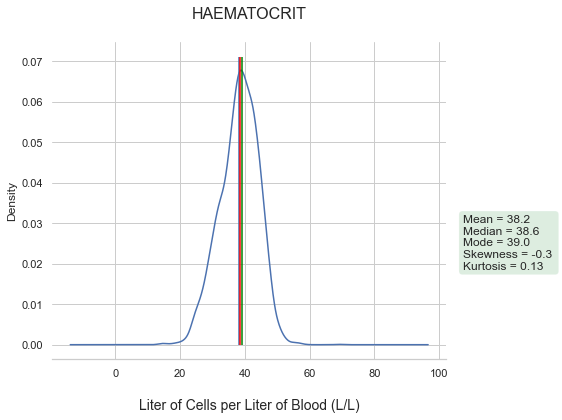

In [16]:
desc_stats_dens_plt(dfp, 'HAEMATOCRIT', 'Liter of Cells per Liter of Blood (L/L)')

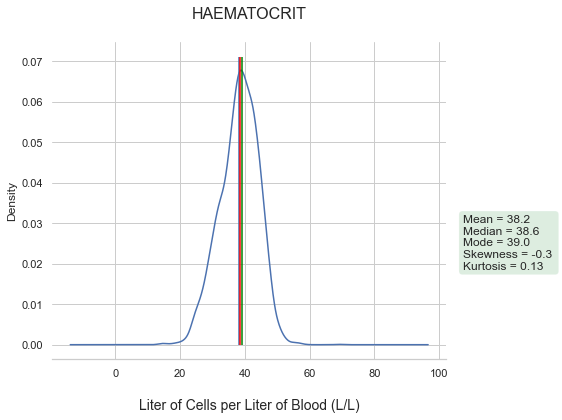

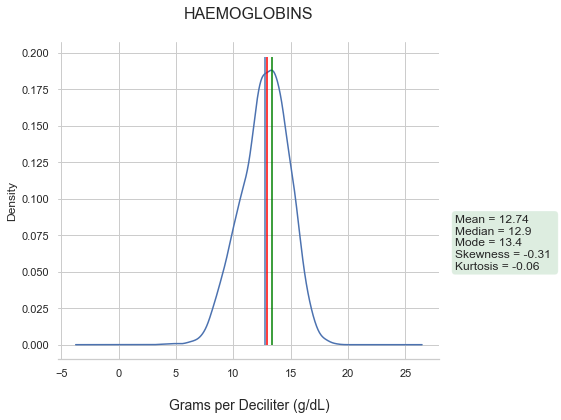

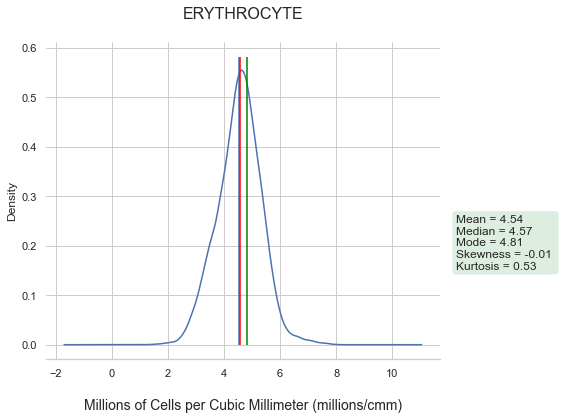

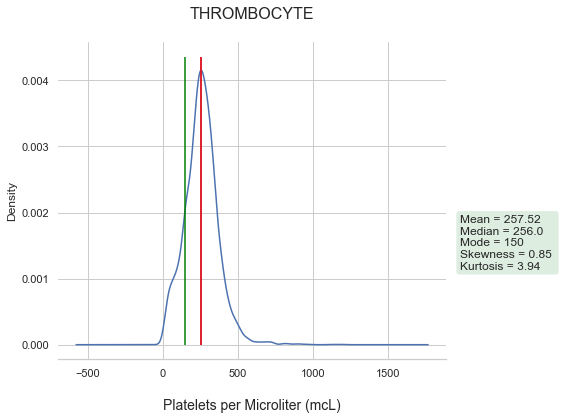

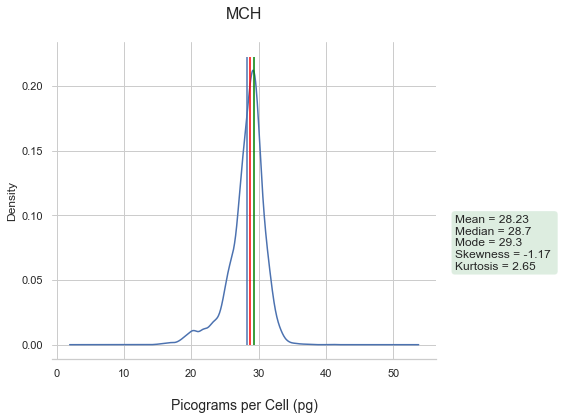

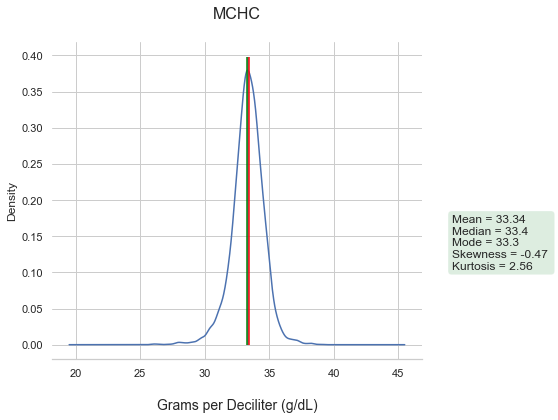

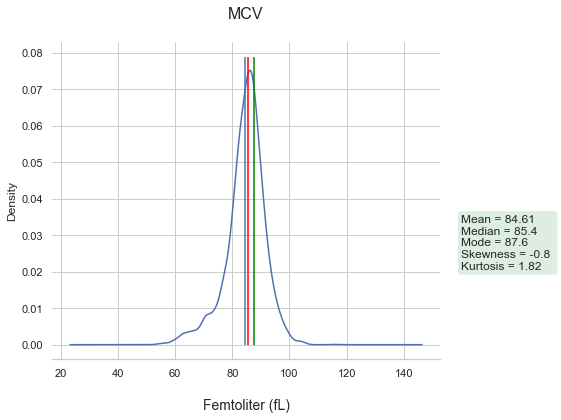

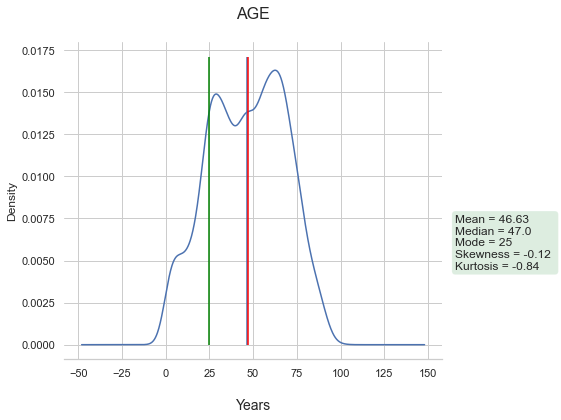

In [17]:
num_cols = ['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE']
xlabel = ['Liter of Cells per Liter of Blood (L/L)','Grams per Deciliter (g/dL)','Millions of Cells per Cubic Millimeter (millions/cmm)',
          'Platelets per Microliter (mcL)','Picograms per Cell (pg)','Grams per Deciliter (g/dL)','Femtoliter (fL)','Years']

for (col, x) in zip(num_cols, xlabel):
    desc_stats_dens_plt(dfp, col, x)


In [18]:
for (col, x) in zip(num_cols, xlabel):
    print(col, x)

HAEMATOCRIT Liter of Cells per Liter of Blood (L/L)
HAEMOGLOBINS Grams per Deciliter (g/dL)
ERYTHROCYTE Millions of Cells per Cubic Millimeter (millions/cmm)
THROMBOCYTE Platelets per Microliter (mcL)
MCH Picograms per Cell (pg)
MCHC Grams per Deciliter (g/dL)
MCV Femtoliter (fL)
AGE Years


### Measures of Dispersion (Numerical)

In [56]:
# find the binary values for the class variable to correctly label the x-axis
dfp['CLASS'].unique().tolist()[0]
dfp['CLASS'].unique().tolist()[1]

'out'

'in'

In [59]:
# create a function for numerical dispersion measures
def desc_stats_box_plt(df, var_x, var_y, label_x, label_y):
    inpatient = df.loc[df[var_x] == 'in']
    outpatient = df.loc[df[var_x] == 'out']
    
    sns.set(style='whitegrid')

    fig = plt.figure(figsize=(8,6))
    
    color1 = df.CLASS.unique().tolist()[0]
    color2 = df.CLASS.unique().tolist()[1]
    my_pal = {f'{color1}': "rebeccapurple", f'{color2}': "seagreen"}
    
    g = ax1 = sns.boxplot(x=df[var_x], y=df[var_y], data=df, palette=my_pal, width=0.7)
    
# title and labels
    plt.title(f'{var_y}\n', fontsize=16)
    plt.ylabel(f'\n{label_y}', fontsize=14)
    ax1.set_xlabel(f'\n{label_x}', fontsize=14)

# x-tick labels
    xvalues = ["Outpatient","Inpatient"]
    
# set xvalues as xtick values
    plt.xticks(np.arange(2), xvalues)
    
# remove all borders except the bottom border
    sns.despine(top=True,
           right=True,
           left=True,
           bottom=False)

# descriptive statistics text-box
# outpatient
    mean = np.round(outpatient[var_y].mean(), 2)
    maximum = np.round(outpatient[var_y].max(), 2)
    u_quan = np.round(outpatient[var_y].quantile(0.75), 2)
    median = np.round(outpatient[var_y].median(), 2)
    l_quan = np.round(outpatient[var_y].quantile(0.25), 2)
    minimum = np.round(outpatient[var_y].min(), 2)
    std = np.round(outpatient[var_y].std(), 2)
# inpatient    
    mean2 = np.round(inpatient[var_y].mean(), 2)
    maximum2 = np.round(inpatient[var_y].max(), 2)
    u_quan2 = np.round(inpatient[var_y].quantile(0.75), 2)
    median2 = np.round(inpatient[var_y].median(), 2)
    l_quan2 = np.round(inpatient[var_y].quantile(0.25), 2)
    minimum2 = np.round(inpatient[var_y].min(), 2)
    std2 = np.round(inpatient[var_y].std(), 2)

    textstr = "Outpatient:\n\n" + "Mean" + f" = {mean} \nMaximum = {maximum} \n3rd Quartile = {u_quan} \nMedian = {median} \n1st Quartile = {l_quan} \nMinimum = {minimum} \nSD = {std} \
    \n\nInpatient:\n\n" + "Mean" + f" = {mean2} \nMaximum = {maximum2} \n3rd Quartile = {u_quan2} \nMedian = {median2} \n1st Quartile = {l_quan2} \nMinimum = {minimum2} \nSD = {std2}"
    props = dict(boxstyle='round', facecolor='deepskyblue', alpha=0.2)
    gtextx1 = (max(ax1.get_xlim())*1.05)
    gtexty1 = np.round(outpatient[var_y].min(), 2)
    g.text(gtextx1, gtexty1, textstr, fontsize=12, bbox=props)
    
    plt.tight_layout()
    plt.show

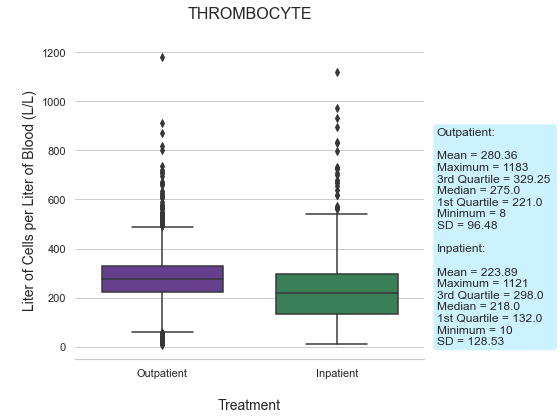

In [60]:
desc_stats_box_plt(dfp, 'CLASS', 'THROMBOCYTE', 'Treatment', 'Liter of Cells per Liter of Blood (L/L)')

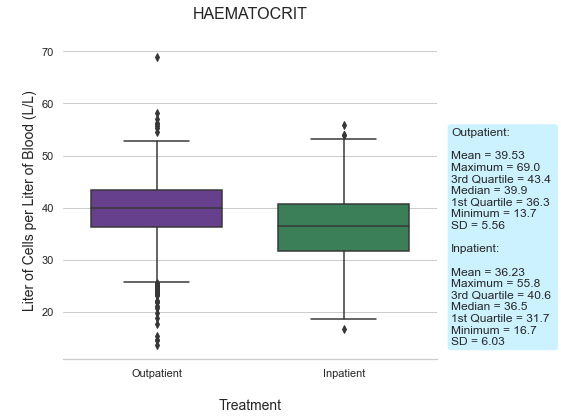

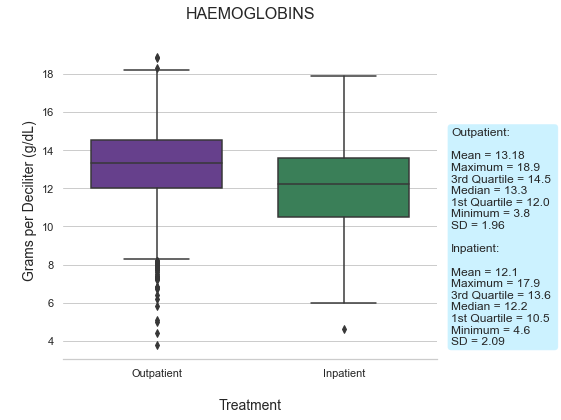

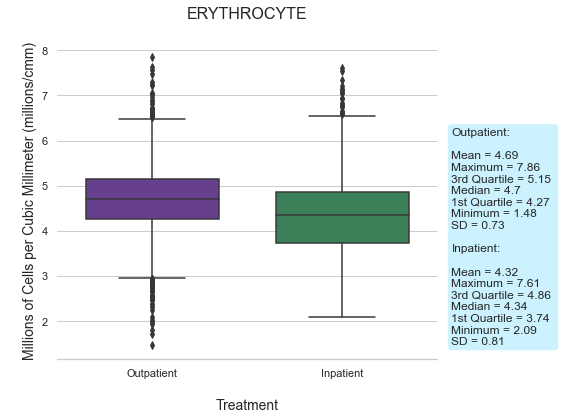

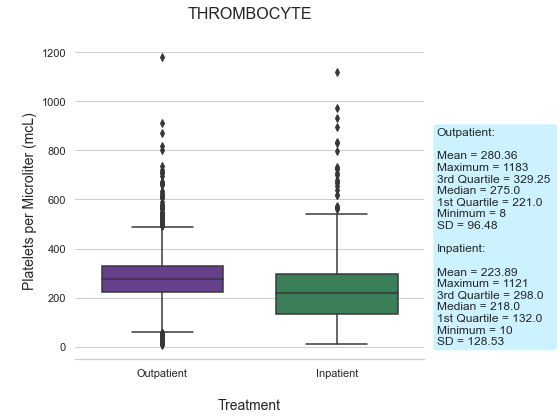

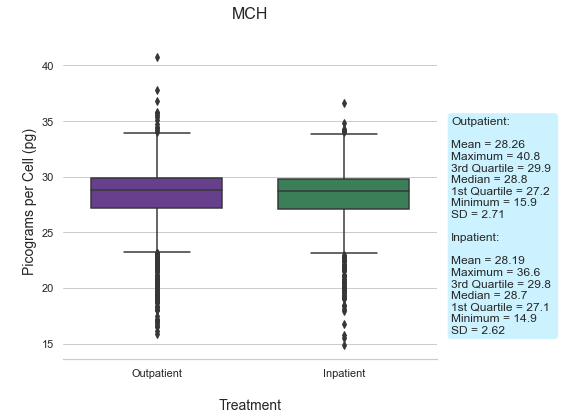

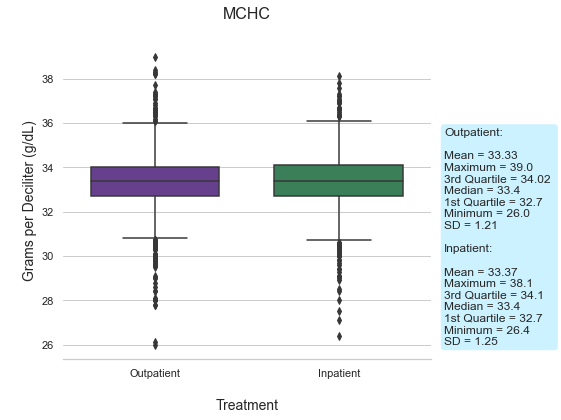

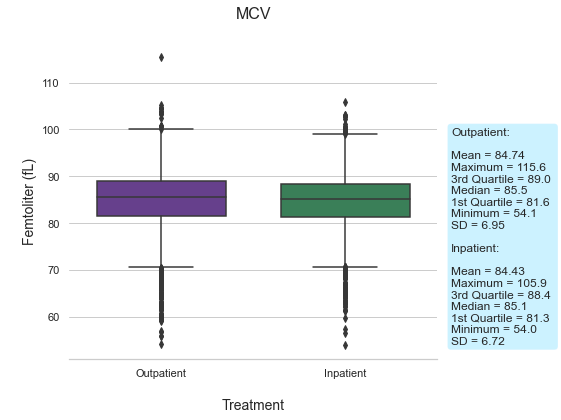

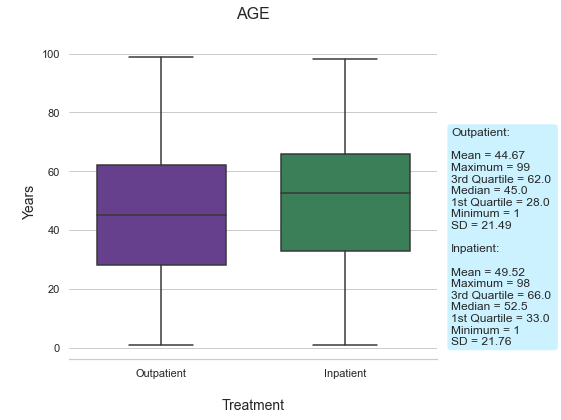

In [61]:
num_cols = ['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE']
label_y = ['Liter of Cells per Liter of Blood (L/L)','Grams per Deciliter (g/dL)','Millions of Cells per Cubic Millimeter (millions/cmm)',
          'Platelets per Microliter (mcL)','Picograms per Cell (pg)','Grams per Deciliter (g/dL)','Femtoliter (fL)','Years']

for (col, y) in zip(num_cols, label_y):
    desc_stats_box_plt(dfp, 'CLASS', col, 'Treatment', y)

## Measures of Dispersion (Categorical)

In [62]:
# create a function for categorical dispersion measures
def cat_bar_plt(df, variable):
    df_plot = df.groupby(['CLASS', f'{variable}']).size().reset_index().pivot(columns='CLASS', index=f'{variable}', values=0)

    df_plot_p = np.round(df_plot.div(df_plot.sum(axis=1), axis=0)*100)

    treatment = ['Inpatient','Outpatient']
    
# set style
    sns.set(style='whitegrid')

    fig = plt.figure(figsize=(8,6))

    ax = df_plot_p.plot(kind='bar', stacked=False)
    plt.title(f'{variable}\n', fontsize=16)
    plt.legend(treatment,loc=3)
    plt.ylabel("Percentage", fontsize=14)
    #ax.set_xlabel(f'{xlabel}', fontsize=14)
    ax.set_xlabel("")
    plt.xticks(rotation = 45)

    for p in ax.patches:
       height = p.get_height()
       ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,
          s="{}%".format(height),
          ha='center')
# remove all borders except the bottom border
    sns.despine(top=True,
               right=True,
               left=True,
               bottom=False)


    fig.tight_layout()
    plt.show()


<Figure size 576x432 with 0 Axes>

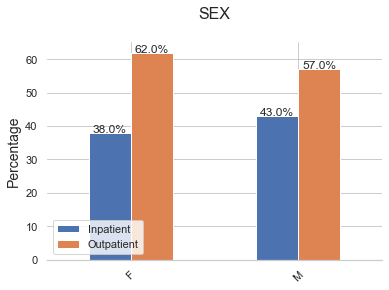

In [63]:
cat_bar_plt(dfp, 'SEX')

In [25]:
df.select("SEX","CLASS").groupBy("SEX","CLASS").count()

SEX,CLASS,count
M,out,1308
F,out,1320
M,in,982
F,in,802


## Univariate, Bivariate, and Multivariate Enumerative Analysis 

### Numerical Variables 

In [26]:
# create a function for the numerical variables
def scatt_strip_plt(df, variable, variable2, ylabel):
# set style
    sns.set(style='whitegrid')

    fig=plt.figure(figsize=(20,5))

    ax = plt.subplot(1,3,1)
    sns.scatterplot(x=df.index,y=df[variable], ax=ax)
    plt.title(f'Scatterplot of {variable}\n', fontsize=16)
    plt.ylabel(f"{ylabel}", fontsize=14)
    ax.set_xlabel("\nIndex", fontsize=14)

# remove all borders except the bottom border
    sns.despine(top=True,
               right=True,
               left=True,
               bottom=False)
    
    ax1 = plt.subplot(1,3,2)
    sns.stripplot(x=df['CLASS'],y=df[variable], palette='husl', ax=ax1)
    plt.title(f'Stripplot of {variable}\n', fontsize=16)
    plt.ylabel(f"{ylabel}", fontsize=14)
    ax1.set_xlabel("\nTreatment", fontsize=14)
    
# x-tick labels
    xvalues = ["Outpatient","Inpatient"]

# set xvalues as xtick values
    plt.xticks(np.arange(2), xvalues)


    #ax.set(ylabel='Milligrams per Decilitre (mg/dL)')
    #ax.set(xlabel='Classification')

# remove all borders except the bottom border
    sns.despine(top=True,
               right=True,
               left=True,
               bottom=False)
    
    ax2 = plt.subplot(1,3,3)
    sns.scatterplot(x=df[variable2],y=df[variable], hue=df['CLASS'], palette='husl', ax=ax2)
    plt.title(f'Scatterplot of {variable}\n', fontsize=16)
    plt.ylabel(f"{ylabel}", fontsize=14)
    ax2.set_xlabel(f'\n{variable2}', fontsize=14)
    ax2.get_legend().set_title("Treatment")
    
    #ax2.set(ylabel='Grams (gms)')
    #ax2.set(xlabel='Albumin')

# remove all borders except the bottom border
    sns.despine(top=True,
               right=True,
               left=True,
               bottom=False)
    
    fig.tight_layout()
    plt.show()

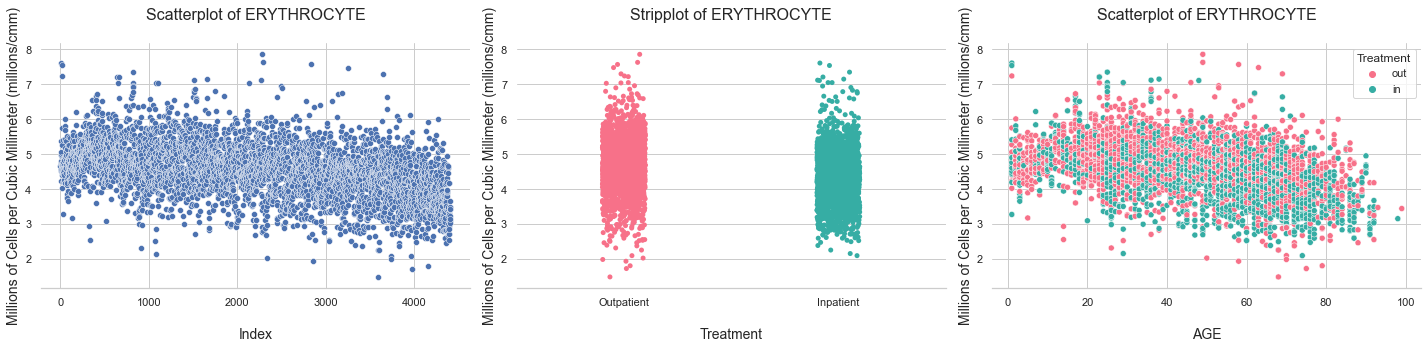

In [27]:
scatt_strip_plt(dfp, 'ERYTHROCYTE', 'AGE', 'Millions of Cells per Cubic Millimeter (millions/cmm)')

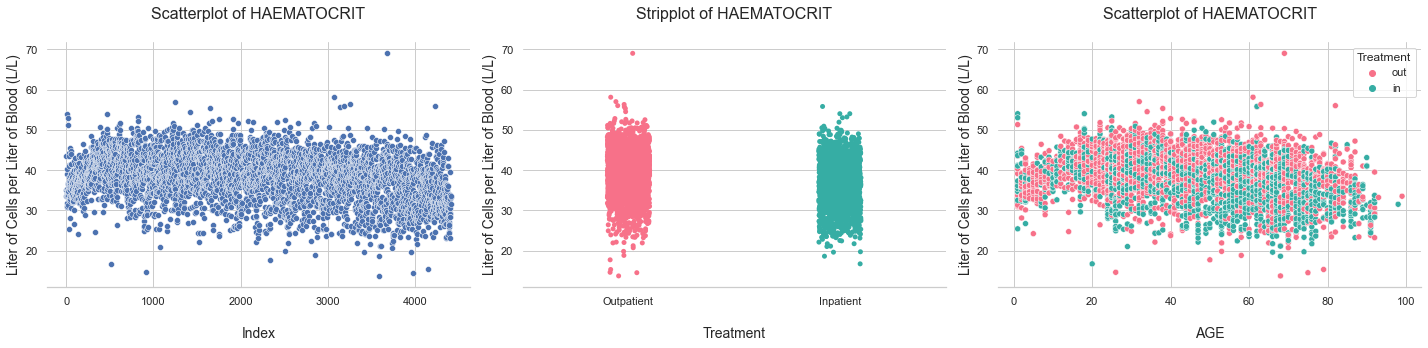

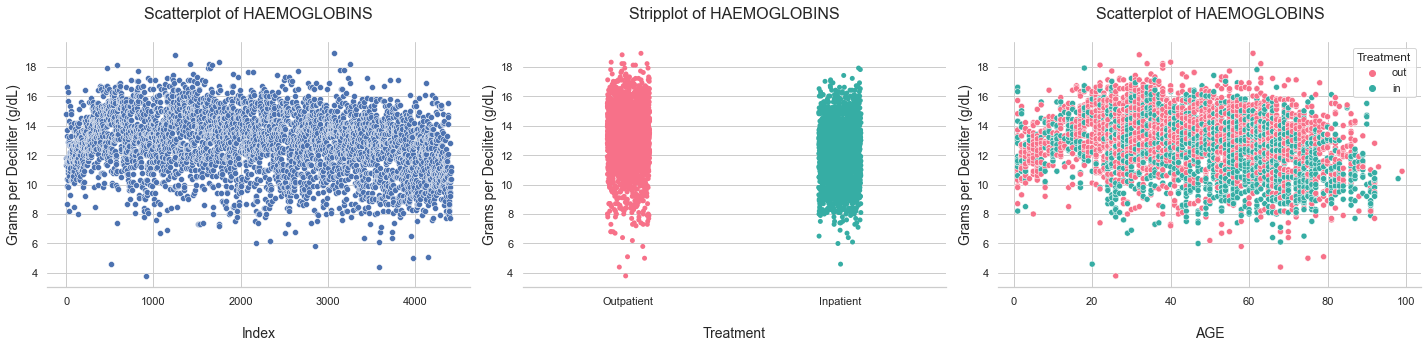

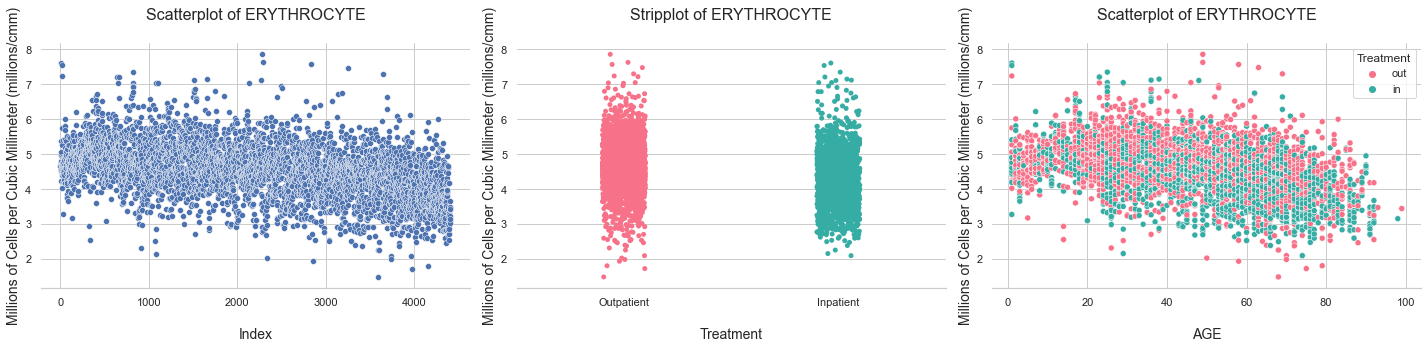

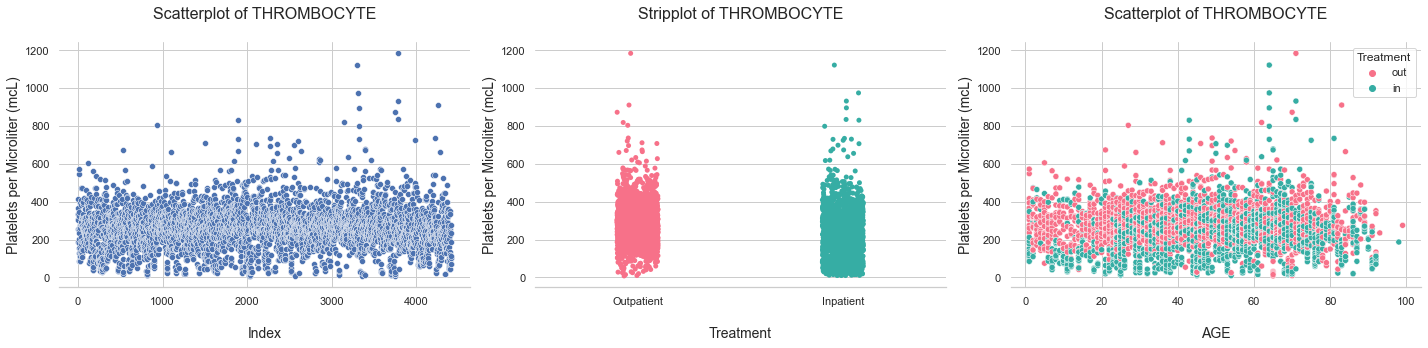

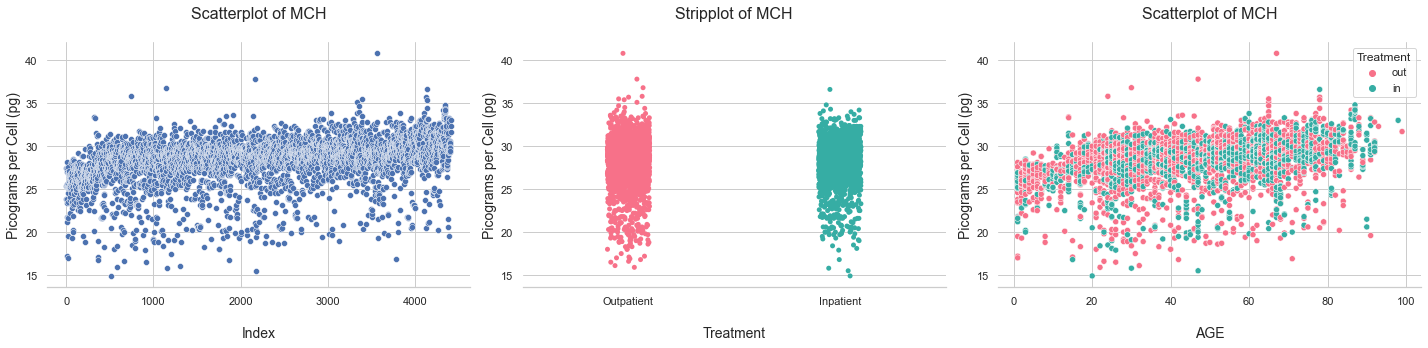

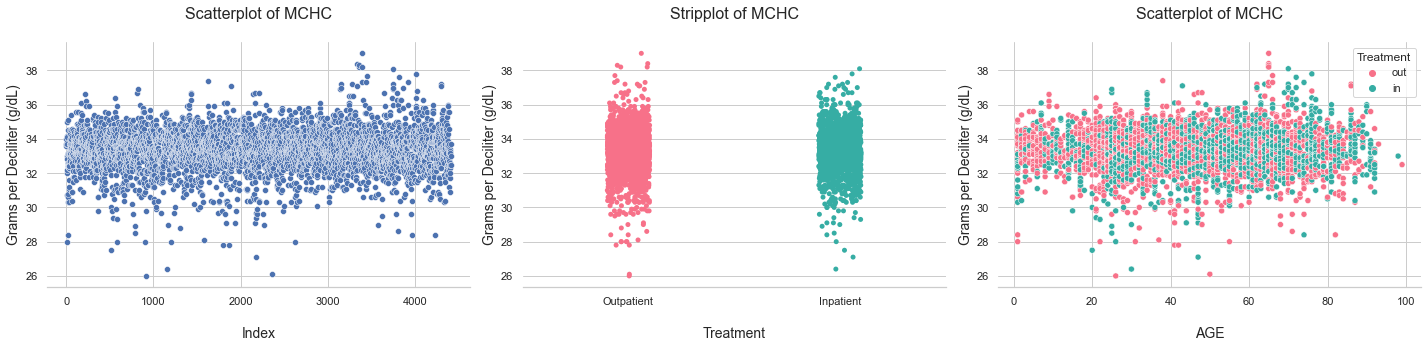

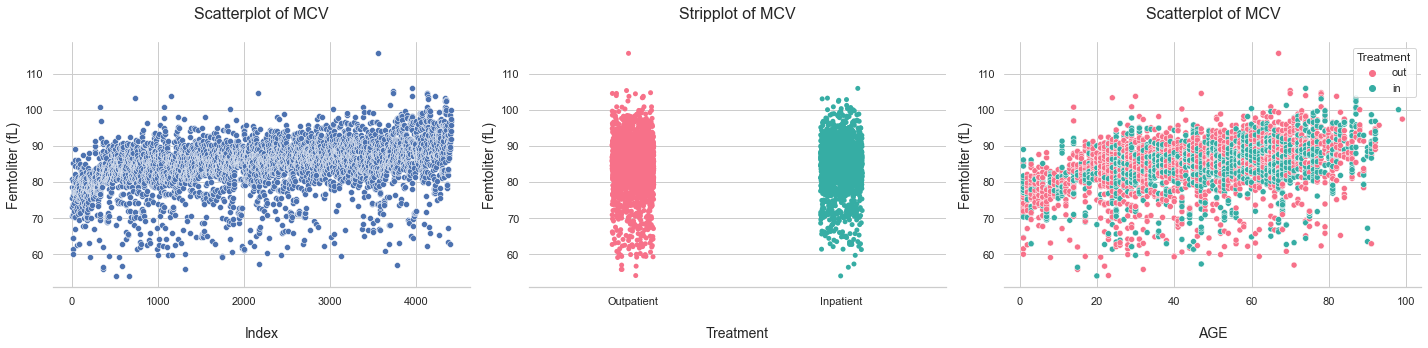

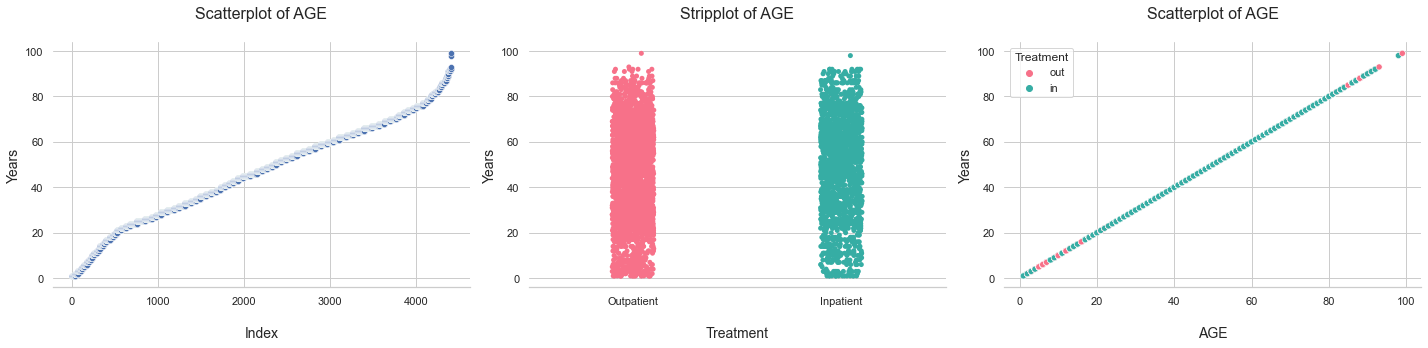

In [28]:
num_cols = ['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE']
ylabel = ['Liter of Cells per Liter of Blood (L/L)','Grams per Deciliter (g/dL)','Millions of Cells per Cubic Millimeter (millions/cmm)',
          'Platelets per Microliter (mcL)','Picograms per Cell (pg)','Grams per Deciliter (g/dL)','Femtoliter (fL)','Years']

for (col, y) in zip(num_cols, ylabel):
    scatt_strip_plt(dfp, col, 'AGE', y)

### Categorical Variables 

In [29]:
def pie_plt(df, variable):
    inpatient = df.loc[df['CLASS'] == 'in']
    outpatient = df.loc[df['CLASS'] == 'out']

# set style
    sns.set(style='whitegrid')

    fig=plt.figure(figsize=(20,20))

    ax1 = plt.subplot(1,3,1)
    plt.title(f'{variable}\n Outpatient & Inpatient', fontsize=16)
    plt.ylabel("Percentage", fontsize=14)
    pie_labels = df[variable].unique().tolist()
    ax1.pie(df[f'{variable}'].value_counts(), startangle=90, autopct='%.3f',
            labels=pie_labels, shadow=True)

    
    
    ax2 = plt.subplot(1,3,2)
    plt.title(f'{variable}\n Outpatient', fontsize=16)
    plt.ylabel("Percentage", fontsize=14)
    ax2.pie(outpatient[f'{variable}'].value_counts(), startangle=90, autopct='%.3f',
            labels=pie_labels, shadow=True)

    ax3 = plt.subplot(1,3,3)
    plt.title(f'{variable}\n Inpatient', fontsize=16)
    plt.ylabel("Percentage", fontsize=14)
    ax3.pie(inpatient[f'{variable}'].value_counts(), startangle=90, autopct='%.3f',
            labels=pie_labels, shadow=True)

    fig.tight_layout()
    plt.show()

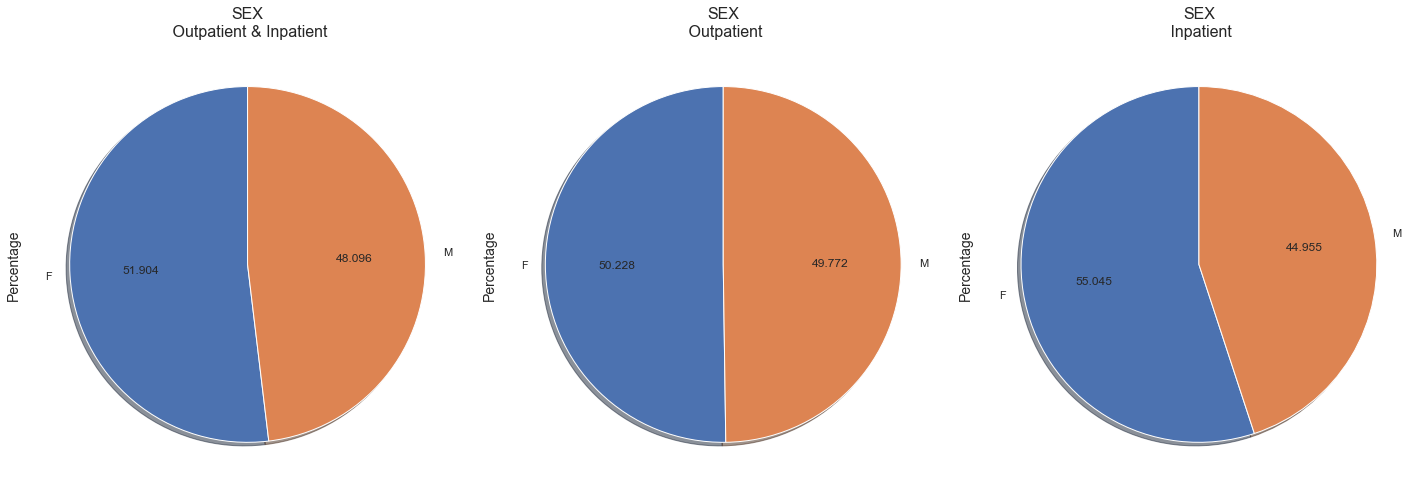

In [30]:
pie_plt(dfp, 'SEX')

## Feature Engineering

In [31]:
# check for a linear relationship between age and class (since age has 99 distinct values)
df.createOrReplaceTempView('df_table')
df_sql = spark.sql('select AGE, CLASS, count(*) as COUNT from df_table where length(CLASS) < 3 group by AGE, CLASS order by AGE')
df_sql.head(99)

#a linear relationship is not present, so QuantileDiscretizer is not needed

[Row(AGE=1, CLASS='in', COUNT=15),
 Row(AGE=2, CLASS='in', COUNT=9),
 Row(AGE=3, CLASS='in', COUNT=13),
 Row(AGE=4, CLASS='in', COUNT=2),
 Row(AGE=5, CLASS='in', COUNT=1),
 Row(AGE=6, CLASS='in', COUNT=7),
 Row(AGE=7, CLASS='in', COUNT=10),
 Row(AGE=8, CLASS='in', COUNT=9),
 Row(AGE=9, CLASS='in', COUNT=6),
 Row(AGE=10, CLASS='in', COUNT=13),
 Row(AGE=11, CLASS='in', COUNT=18),
 Row(AGE=12, CLASS='in', COUNT=10),
 Row(AGE=13, CLASS='in', COUNT=3),
 Row(AGE=14, CLASS='in', COUNT=19),
 Row(AGE=15, CLASS='in', COUNT=10),
 Row(AGE=16, CLASS='in', COUNT=5),
 Row(AGE=17, CLASS='in', COUNT=16),
 Row(AGE=18, CLASS='in', COUNT=13),
 Row(AGE=19, CLASS='in', COUNT=5),
 Row(AGE=20, CLASS='in', COUNT=5),
 Row(AGE=21, CLASS='in', COUNT=7),
 Row(AGE=22, CLASS='in', COUNT=15),
 Row(AGE=23, CLASS='in', COUNT=15),
 Row(AGE=24, CLASS='in', COUNT=29),
 Row(AGE=25, CLASS='in', COUNT=44),
 Row(AGE=26, CLASS='in', COUNT=34),
 Row(AGE=27, CLASS='in', COUNT=11),
 Row(AGE=28, CLASS='in', COUNT=11),
 Row(AGE=29,

In [37]:
# convert the categorical variables to numbers; create label and features columns
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'CLASS', outputCol = 'label')
stages += [label_stringIdx]
#AGE_BIN = QuantileDiscretizer(numBuckets=4, inputCol="AGE", outputCol="AGE_BIN")
#stage += [AGE_BIN]
#num_cols = ['HAEMATOCRIT','HAEMOGLOBIN','ERYTHROCYTE','THROMBOCYTE','MCH','MCHC','MCV','AGE_BIN']
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [38]:
stages

[StringIndexer_d5af40d198e9,
 OneHotEncoder_5b8b6af61865,
 StringIndexer_a457fe74665e,
 OneHotEncoder_0666104a0b60,
 StringIndexer_ca3360faf045,
 VectorAssembler_847a607c0828]

In [39]:
# store the columns
cols = df.columns

# create the pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- HAEMATOCRIT: double (nullable = true)
 |-- HAEMOGLOBINS: double (nullable = true)
 |-- ERYTHROCYTE: double (nullable = true)
 |-- LEUCOCYTE: double (nullable = true)
 |-- THROMBOCYTE: integer (nullable = true)
 |-- MCH: double (nullable = true)
 |-- MCHC: double (nullable = true)
 |-- MCV: double (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SEX: string (nullable = true)
 |-- CLASS: string (nullable = true)



In [44]:
df.toPandas().head()

,label,features,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,CLASS
0,0.0,"[0.0, 1.0, 35.1, 11.8, 4.65, 310.0, 25.4, 33.6...",35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,0.0,"[0.0, 1.0, 43.5, 14.8, 5.39, 334.0, 27.5, 34.0...",43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,0.0,"[0.0, 1.0, 33.5, 11.3, 4.74, 305.0, 23.8, 33.7...",33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,0.0,"[0.0, 1.0, 39.1, 13.7, 4.98, 366.0, 27.5, 35.0...",39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,0.0,"[1.0, 1.0, 30.9, 9.9, 4.23, 333.0, 23.4, 32.0,...",30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [40]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed = 137)
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 3121
Test Dataset Count: 1291


## Predictive Modeling 

### Logistic Regression 

In [43]:
# create the model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)


# train the model on the training data
lrModel = lr.fit(train_df)

In [44]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.24704086518505655,-15.792496081452025,-0.018850307450129267,-0.05528050930810092,-0.1034135421649273,-0.0018714787694568984,-0.023623254265926118,0.011626038364106583,-0.007879305708252812,0.0018996273244566838]
Intercept: 10.949111253058243


In [63]:
# get training model metrics
summary=lrModel.summary

accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
     % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall, summary.areaUnderROC))

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0
AreaUnderROC: 0.9999995724211651


C:\Users\medma\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

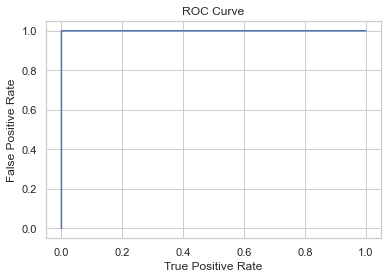

Training Set AreaUnderROC: 0.9999995724211651


In [48]:
# plot the area under the curve
roc = summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training Set AreaUnderROC: ' + str(summary.areaUnderROC))

C:\Users\medma\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Text(0, 0.5, 'Precision')

Text(0.5, 0, 'Recall')

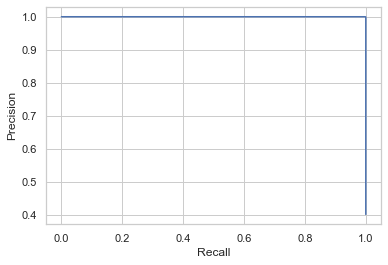

In [49]:
# plot the precision and recall
pr = summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [57]:
# use the lr model to make predictions on the test data
predictions = lrModel.transform(test_df)
predictions.select('label','rawPrediction','probability','prediction').toPandas().head(20)
predictions.select('label','prediction').toPandas().head(20)

,label,rawPrediction,probability,prediction
0,0.0,"[6.918983110918797, -6.918983110918797]","[0.9990121418637412, 0.0009878581362587902]",0.0
1,0.0,"[7.215523016768577, -7.215523016768577]","[0.9992654539236678, 0.0007345460763321654]",0.0
2,0.0,"[7.750505042188495, -7.750505042188495]","[0.9995696602197112, 0.00043033978028883535]",0.0
3,0.0,"[7.616770536334707, -7.616770536334707]","[0.999508113492482, 0.000491886507517969]",0.0
4,0.0,"[7.386081721717533, -7.386081721717533]","[0.999380564110374, 0.0006194358896259855]",0.0
5,0.0,"[7.3461675837700415, -7.3461675837700415]","[0.9993553560670742, 0.000644643932925848]",0.0
6,0.0,"[7.220861152584176, -7.220861152584176]","[0.9992693617260061, 0.0007306382739938888]",0.0
7,0.0,"[7.188199155625467, -7.188199155625467]","[0.9992451219302364, 0.0007548780697635982]",0.0
8,0.0,"[7.71053663117482, -7.71053663117482]","[0.9995521197282274, 0.0004478802717725605]",0.0
9,0.0,"[7.078387106282113, -7.078387106282113]","[0.9991575783381097, 0.0008424216618903024]",0.0


,label,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [67]:
test_df.groupBy('CLASS').count().show()

+-----+-----+
|CLASS|count|
+-----+-----+
|   in|  534|
|  out|  757|
+-----+-----+



In [65]:
# get test model metrics
results = predictions.select(['prediction','label'])
count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
incorrect = results.filter(results.prediction != results.label).count()
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Correct: %s\nIncorrect: %s\nAccuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
     % (correct, incorrect, accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall, summary.areaUnderROC))


Correct: 1291
Incorrect: 0
Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0
AreaUnderROC: 0.9999995724211651


In [54]:
# evaluate the logistic regression model
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [59]:
# create a ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_df)
predictions = cvModel.bestModel.transform(test_df)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [61]:
evaluator.getMetricName()

'areaUnderROC'

In [60]:
cvModel.explainParams()

"estimator: estimator to be cross-validated (current: LogisticRegression_a1385f259e75)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_a1385f259e75', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_a1385f259e75', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_a1385f259e75', name='maxIter', doc='max number of iterations (>= 0).'): 1}, {Param(parent='LogisticRegression_a1385f259e75', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_a1385f259e75', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_a1385f259e75', name='maxIter', doc='max number of iterations

### Decision Tree 

In [68]:
# create the model
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3).setSeed(2934)

# train the model
dtModel = dt.fit(train_df)

In [76]:
# make predictions on the test data
predictions = dtModel.transform(test_df)
predictions.select('HAEMATOCRIT','AGE','label','rawPrediction','probability','prediction').toPandas().head(20)

,HAEMATOCRIT,AGE,label,rawPrediction,probability,prediction
0,13.7,68,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
1,18.8,58,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
2,24.6,49,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
3,25.0,43,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
4,25.2,71,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
5,25.7,74,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
6,25.8,79,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
7,26.4,65,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
8,26.5,76,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0
9,26.9,65,0.0,"[1871.0, 0.0]","[1.0, 0.0]",0.0


In [73]:
# get test model metrics
results = predictions.select(['prediction','label'])
count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
incorrect = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Correct: %s\nIncorrect: %s\nTrue Positive Rate: %s\nFalse Positive Rate: %s\nTrue Negative Rate: %s\nFalse Negative Rate: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, incorrect, tp, fp, tn, fn, accuracy, precision, recall))


Correct: 1291
Incorrect: 0
True Positive Rate: 534
False Positive Rate: 0
True Negative Rate: 757
False Negative Rate: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [77]:
# evaluate the decision tree model
evaluator = BinaryClassificationEvaluator()
print('Test Ar ea Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


## Random Forest 

In [79]:
# create the model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label').setMaxDepth(6).setNumTrees(50).setFeatureSubsetStrategy("auto").setSeed(5615)

# train the model
rfModel = rf.fit(train_df)

In [80]:
# make predictions on the test data
predictions = rfModel.transform(test_df)
predictions.select('LEUCOCYTE','MCH','label','rawPrediction','probability','prediction').toPandas().head(20)

,LEUCOCYTE,MCH,label,rawPrediction,probability,prediction
0,5.3,29.7,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0
1,9.9,30.1,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0
2,22.5,28.3,0.0,"[49.875, 0.125]","[0.9975, 0.0025]",0.0
3,11.7,26.8,0.0,"[49.77777777777778, 0.2222222222222222]","[0.9955555555555555, 0.0044444444444444444]",0.0
4,7.7,31.3,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0
5,15.3,31.5,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0
6,5.8,33.2,0.0,"[49.0, 1.0]","[0.98, 0.02]",0.0
7,7.1,34.0,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0
8,9.7,27.9,0.0,"[49.29801324503311, 0.7019867549668874]","[0.9859602649006622, 0.01403973509933775]",0.0
9,5.7,29.7,0.0,"[50.0, 0.0]","[1.0, 0.0]",0.0


In [81]:
# get test model metrics
results = predictions.select(['prediction','label'])
count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
incorrect = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()

accuracy = (tp+tn)/count
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Correct: %s\nIncorrect: %s\nTrue Positive Rate: %s\nFalse Positive Rate: %s\nTrue Negative Rate: %s\nFalse Negative Rate: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
     % (correct, incorrect, tp, fp, tn, fn, accuracy, precision, recall))


Correct: 1291
Incorrect: 0
True Positive Rate: 534
False Positive Rate: 0
True Negative Rate: 757
False Negative Rate: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [82]:
# evaluate the decision tree model
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0
